# Structure Characterization

In [1]:
%load_ext autoreload
%autoreload 2

import re
import numpy as np
import matplotlib.pyplot as plt
import glob
import matplotlib.lines as mlines
from matplotlib.cm import get_cmap

from sro_sto_plume.xrd_ref import calculate_2theta, plot_ref_xrd
from m3util.viz.layout import layout_fig
from m3util.viz.text import labelfigs, add_text_to_figure
from m3util.viz.lines import draw_lines
from xrd_learn.xrd_viz import plot_xrd
from xrd_learn.xrd_utils import detect_peaks, calculate_fwhm
from xrd_learn.rsm_viz import RSMPlotter
from xrd_learn.xrd_utils import load_xrd_scans, align_peak_to_value
from afm_learn.afm_viz import visualize_afm_image
from afm_learn.afm_utils import parse_ibw, format_func

## 1. XRD

In [2]:
files = ['../data/XRD_RSM/YG065/YG065_2theta-Omega_Path1_42-49 degree_slow_2.xrdml',
         '../data/XRD_RSM/YG066/YG066 2theta-Omega_Path1_42-49 degree_slow_2.xrdml',
         '../data/XRD_RSM/YG067/YG067 2theta-Omega_Path1_42-49 degree_slow_2 1.xrdml',
         '../data/XRD_RSM/YG068/YG068 2theta-Omega_Path1_42-49 degree_slow_2.xrdml',
         '../data/XRD_RSM/YG069/YG069 2theta-Omega_Path1_42-49 degree_slow_2.xrdml',
         ]
sample_names = ['Sample 1', 'Sample 2', 'Sample 3', 'Sample 4', 'Sample 5']

Xs, Ys, length_list = load_xrd_scans(files)

### 1.1 Visualize XRD

In [3]:
# Example: SrTiO3 (002) reflection
two_theta_value = calculate_2theta(hkl=(0, 0, 2), abc=(3.905, 3.905, 3.905))
print(f"2θ for STO (002) reflection: {two_theta_value:.4f}°")

two_theta_value = calculate_2theta(hkl=(2, 2, 0), abc=(5.567, 5.530, 7.845))
print(f"2θ for SRO (220) reflection: {two_theta_value:.4f}°")

2θ for STO (002) reflection: 46.4721°
2θ for SRO (220) reflection: 46.2425°


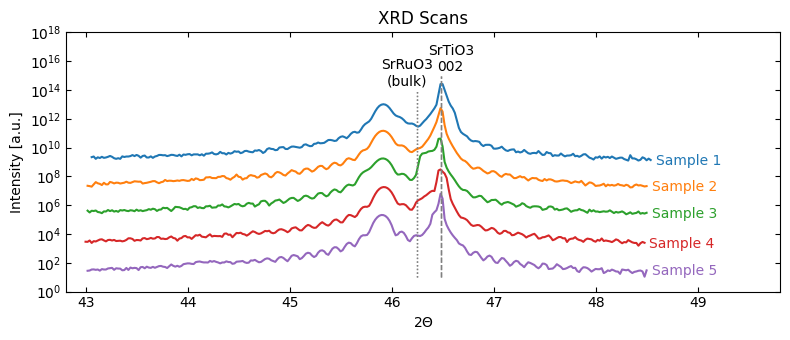

In [23]:
STO_x_peak = 46.4721
SRO_bulk_x_peak = 46.2425

Xs_aligned, Ys_aligned = align_peak_to_value(Xs, Ys, STO_x_peak, viz=False)
fig, ax = plt.subplots(1, 1, figsize=(8, 3.5))
plot_xrd((Xs_aligned, Ys_aligned, length_list), sample_names, title='XRD Scans', xrange=(42.8, 49.8), yrange=(1, 1e18), diff=1e2, fig=fig, ax=ax, legend_style='label', text_offset_ratio=(1.001, 0.45))

line_style = {'color': 'gray', 'linestyle': 'dashed', 'linewidth': 1}
draw_lines(ax, x_values=[STO_x_peak, STO_x_peak], y_values=[1e1, 1e15], style=line_style)
ax.text(STO_x_peak+0.1, 2e15, 'SrTiO3\n002', fontsize=10, ha='center')

line_style = {'color': 'gray', 'linestyle': 'dotted', 'linewidth': 1}
draw_lines(ax, x_values=[SRO_bulk_x_peak, SRO_bulk_x_peak], y_values=[1e1, 1e14], style=line_style)
ax.text(SRO_bulk_x_peak-0.1, 2e14, 'SrRuO3\n(bulk)', fontsize=10, ha='center')

plt.tight_layout()
plt.show()

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

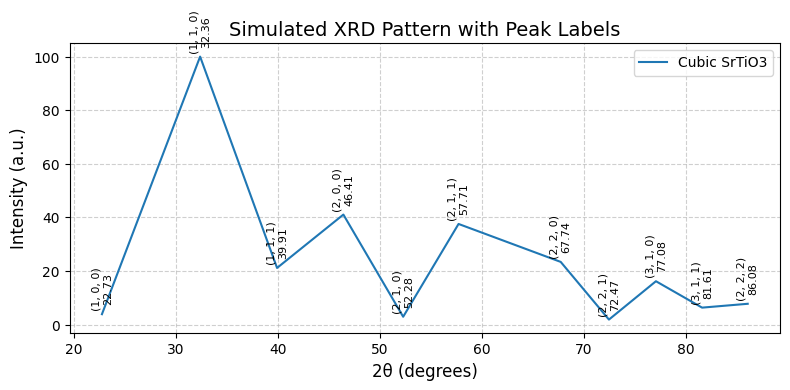

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

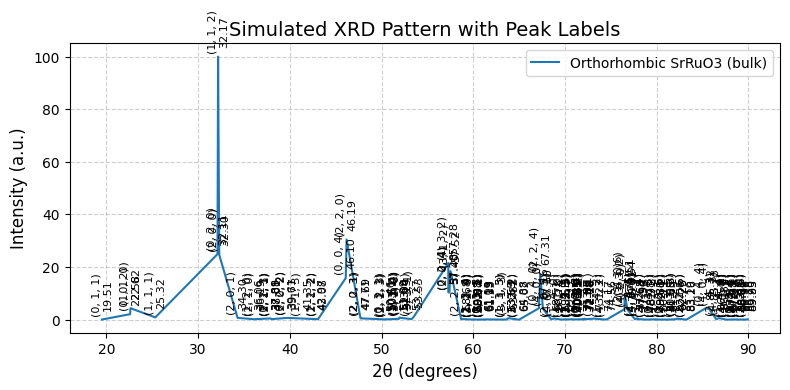

In [24]:
api_key = 'fpkmDzflX03EpKg0aOsda6u6aLJ7Bkpm'
plot_ref_xrd(api_key=api_key, material_id='mp-5229', label='Cubic SrTiO3') # Cubic SrTiO3
plot_ref_xrd(api_key=api_key, material_id='mp-22390', label='Orthorhombic SrRuO3 (bulk)') # Orthorhombic SrRuO3

### 1.2 Find Peaks

In [25]:
for i, (X, Y, sample_name) in enumerate(zip(Xs, Ys, sample_names)):
    peak_x, peak_y = detect_peaks(X, Y, num_peaks=2, prominence=0.1, distance=None)
    print(peak_x, peak_y)

[46.4721, 45.912099999999995] [2568384.659090909, 101747.72727272728]
[46.4721, 45.912099999999995] [5478935.795454546, 146346.5909090909]
[46.4721, 45.912099999999995] [4234064.7727272725, 175297.1590909091]
[46.4721, 45.912099999999995] [3027654.5454545454, 180489.77272727274]
[46.4721, 45.8921] [6168907.386363637, 208056.25]


C:\Users\yig319\AppData\Local\Temp\ipykernel_44516\793476632.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = get_cmap('tab10').colors[:5]


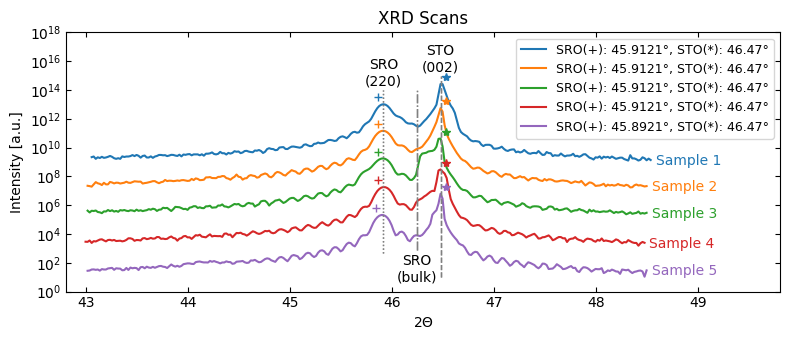

In [26]:
Xs_aligned, Ys_aligned = align_peak_to_value(Xs, Ys, STO_x_peak, viz=False)

fig, ax = plt.subplots(1, 1, figsize=(8, 3.5))
diff = 1e2
plot_xrd((Xs_aligned, Ys_aligned, length_list), sample_names, title='XRD Scans', xrange=(42.8, 49.8), yrange=(1, 1e18), diff=diff, fig=fig, ax=ax, legend_style='label', text_offset_ratio=(1.001, 0.45))

line_style = {'color': 'gray', 'linestyle': 'dashed', 'linewidth': 1}
draw_lines(ax, x_values=[STO_x_peak, STO_x_peak], y_values=[1e1, 1e15], style=line_style)
ax.text(STO_x_peak, 2e15, 'STO\n(002)', fontsize=10, ha='center')

ax.text(45.9121, 2e14, 'SRO\n(220)', fontsize=10, ha='center')
line_style = {'color': 'gray', 'linestyle': 'dotted', 'linewidth': 1}
draw_lines(ax, x_values=[45.9121, 45.9121], y_values=[5e2, 1e14], style=line_style)

ax.text(SRO_bulk_x_peak, 5, 'SRO\n(bulk)', fontsize=10, ha='center')
line_style = {'color': 'gray', 'linestyle': 'dashdot', 'linewidth': 1}
draw_lines(ax, x_values=[SRO_bulk_x_peak, SRO_bulk_x_peak], y_values=[8e2, 1e14], style=line_style)

legend = []
colors = get_cmap('tab10').colors[:5]
for i, (X, Y, sample_name, color) in enumerate(zip(Xs_aligned, Ys_aligned, sample_names, colors)):
    peak_x, peak_y = detect_peaks(X, Y, num_peaks=2, prominence=0.1, distance=None)

    # Prepare legend item
    legend_item = f'SRO(+): {peak_x[1]:.4f}°, STO(*): {peak_x[0]:.4}°'
    legend.append(legend_item)
    
    peak_y = np.array(peak_y)*diff**(len(Ys)-i-1)
    plt.plot(peak_x[0]+0.05, peak_y[0]*3, '*', color=color)
    plt.plot(peak_x[1]-0.05, peak_y[1]*3, '+', color=color)
    
plt.legend(legend, fontsize=9, loc='upper right')
plt.tight_layout()
plt.show()

### 1.3 Full Width at Half Maximum (FWHM) 

C:\Users\yig319\AppData\Local\Temp\ipykernel_44516\2108268747.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = get_cmap('tab10').colors[:5]


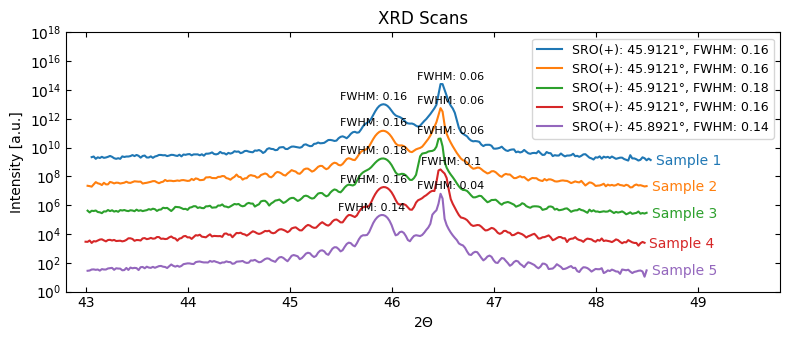

In [27]:
Xs, Ys = align_peak_to_value(Xs, Ys, STO_x_peak, viz=False)

fig, ax = plt.subplots(1, 1, figsize=(8, 3.5))
diff = 1e2

plot_xrd((Xs, Ys, length_list), sample_names, title='XRD Scans', 
         xrange=(42.8, 49.8), yrange=(1, 1e18), diff=diff, 
         fig=fig, ax=ax, legend_style='label', text_offset_ratio=(1.001, 0.45))

legend = []
colors = get_cmap('tab10').colors[:5]

for i, (X, Y, sample_name, color) in enumerate(zip(Xs, Ys, sample_names, colors)):
    # Detect peaks
    peak_x, peak_y = detect_peaks(X, Y, num_peaks=2, prominence=0.1, distance=None)
    
    # Calculate FWHM for the STO peak (peak_x[0]) and SRO peak (peak_x[1])
    fwhm_sto, y_fwhm_sto, x_left_sto, x_right_sto = calculate_fwhm(X, Y, peak_x[0])
    fwhm_sro, y_fwhm_sro, x_left_sro, x_right_sro = calculate_fwhm(X, Y, peak_x[1])

    # Prepare legend item
    legend_item = f'SRO(+): {peak_x[1]:.4f}°, STO(*): {peak_x[0]:.4}°'
    legend_item = f'SRO(+): {peak_x[1]:.4f}°, FWHM: {fwhm_sro:.2f}'
    legend.append(legend_item)

    # Adjust y-values for plotting
    peak_y = np.array(peak_y) * diff ** (len(Ys) - i - 1)

    # Draw FWHM arrows for both peaks
    ax.text(peak_x[0]+0.1, peak_y[0] * 2, f'FWHM: {fwhm_sto:.2}',
            ha='center', fontsize=8)
    ax.text(peak_x[1]-0.1, peak_y[1] * 2, f'FWHM: {fwhm_sro:.2f}',
            ha='center', fontsize=8)

# Add legend and adjust layout
plt.legend(legend, fontsize=9)
plt.tight_layout()
plt.show()

### 1.4 Summarized XRD scans

C:\Users\yig319\AppData\Local\Temp\ipykernel_44516\3716130130.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = get_cmap('tab10').colors[:5]


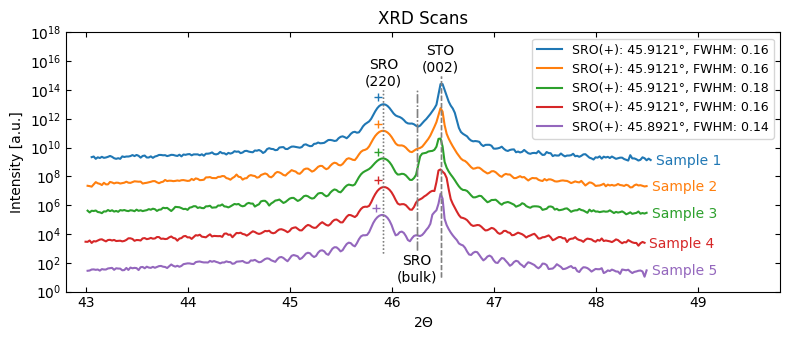

In [28]:
Xs_aligned, Ys_aligned = align_peak_to_value(Xs, Ys, STO_x_peak, viz=False)

fig, ax = plt.subplots(1, 1, figsize=(8, 3.5))
diff = 1e2
plot_xrd((Xs_aligned, Ys_aligned, length_list), sample_names, title='XRD Scans', xrange=(42.8, 49.8), yrange=(1, 1e18), diff=diff, fig=fig, ax=ax, legend_style='label', text_offset_ratio=(1.001, 0.45))

line_style = {'color': 'gray', 'linestyle': 'dashed', 'linewidth': 1}
draw_lines(ax, x_values=[STO_x_peak, STO_x_peak], y_values=[1e1, 1e15], style=line_style)
ax.text(STO_x_peak, 2e15, 'STO\n(002)', fontsize=10, ha='center')

ax.text(45.9121, 2e14, 'SRO\n(220)', fontsize=10, ha='center')
line_style = {'color': 'gray', 'linestyle': 'dotted', 'linewidth': 1}
draw_lines(ax, x_values=[45.9121, 45.9121], y_values=[5e2, 1e14], style=line_style)

ax.text(SRO_bulk_x_peak, 5, 'SRO\n(bulk)', fontsize=10, ha='center')
line_style = {'color': 'gray', 'linestyle': 'dashdot', 'linewidth': 1}
draw_lines(ax, x_values=[SRO_bulk_x_peak, SRO_bulk_x_peak], y_values=[8e2, 1e14], style=line_style)

legend = []
colors = get_cmap('tab10').colors[:5]
for i, (X, Y, sample_name, color) in enumerate(zip(Xs_aligned, Ys_aligned, sample_names, colors)):
    peak_x, peak_y = detect_peaks(X, Y, num_peaks=2, prominence=0.1, distance=None)

    # Calculate FWHM for the STO peak (peak_x[0]) and SRO peak (peak_x[1])
    fwhm_sto, y_fwhm_sto, x_left_sto, x_right_sto = calculate_fwhm(X, Y, peak_x[0])
    fwhm_sro, y_fwhm_sro, x_left_sro, x_right_sro = calculate_fwhm(X, Y, peak_x[1])

    # Prepare legend item
    legend_item = f'SRO(+): {peak_x[1]:.4f}°, STO(*): {peak_x[0]:.4}°'
    legend_item = f'SRO(+): {peak_x[1]:.4f}°, FWHM: {fwhm_sro:.2f}'
    legend.append(legend_item)
    
    peak_y = np.array(peak_y)*diff**(len(Ys)-i-1)
    # plt.plot(peak_x[0], peak_y[0]*3, '*', color=color)
    plt.plot(peak_x[1]-0.05, peak_y[1]*3, '+', color=color)
    
plt.legend(legend, fontsize=9, loc='upper right')
plt.tight_layout()
plt.savefig('../figures/s2_XRD_Scans.png', dpi=300)
plt.show()

## 2. Reciprocal Space Mapping (RSM)

In [29]:
from skimage.feature import peak_local_max

files = ['../data/XRD_RSM/YG065/YG065_RSM slow 3 degree_1.xrdml',
         '../data/XRD_RSM/YG066/YG066 STO 103 phi 94.64 RSM slow 3 degree_1.xrdml',
         '../data/XRD_RSM/YG067/YG067 STO 103 phi_-3.77 RSM slow 3 degree_1 1.xrdml',
         '../data/XRD_RSM/YG068/YG068 STO 103 RSM phi at -176 slow 3 degree_1.xrdml',
         '../data/XRD_RSM/YG069/YG069 STO 103 RSM phi at -88.75 slow 3 degree_1.xrdml']
sample_names = ['Sample 1', 'Sample 2', 'Sample 3', 'Sample 4', 'Sample 5']

plot_params = {
    "reciprocal_space": True,
    'title': None,
    'figsize': None, 
    "cmap": plt.cm.viridis,
    "xlim": (1.572, 1.64),
    "ylim": (4.72, 4.86),
    "fontsize": 8,
    "log_scale": True,
    "cbar_value_format": 'actual',
    "cbar_levels": 20,
    "cbar_ticks": 10,
    "cbar_fraction": 0.05,
    "cbar_pad":  0.02,
    'show_xaxis': 'last',
    'show_yaxis': 'first',
    "vmin": 3,
    "vmax": 1000,
    'custom_bg_color': None,
    'save_path': None,
}
plotter = RSMPlotter(plot_params)

C:\Users\yig319\AppData\Local\Temp\ipykernel_44516\3125163024.py:6: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


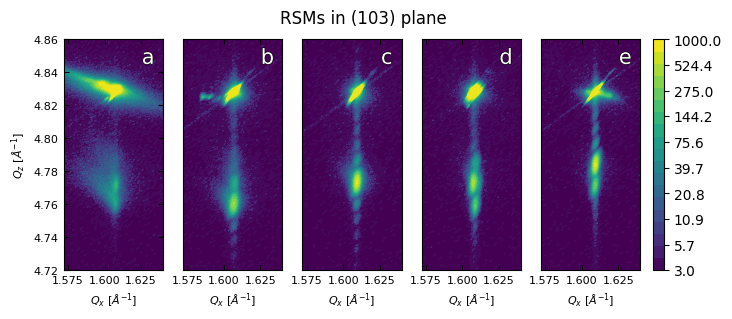

In [30]:
fig, axes = layout_fig(graph=len(files), mod=5, figsize=(8, 3), subplot_style='gridspec', spacing=(0.2, 0.2), layout='tight')
for i, (ax, file, title) in enumerate(zip(axes, files, sample_names)):
    Qx, Qz, intensity = plotter.plot(file, fig, ax, figsize=None)
    labelfigs(ax, i, size=15, inset_fraction=(0.08, 0.15), loc='tr')
plt.suptitle('RSMs in (103) plane')
plt.tight_layout()
# plt.savefig('../figures/1_RSMs_plain.png', dpi=300, bbox_inches='tight')
plt.show()

### 2.2 Full Width at Half Maximum (FWHM) 

C:\Users\yig319\AppData\Local\Temp\ipykernel_44516\2151688915.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


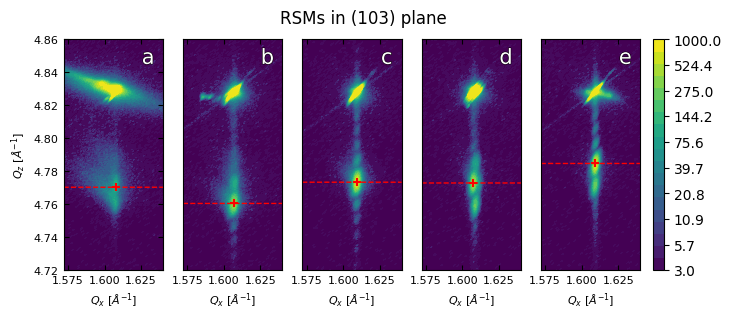

In [31]:
fig, axes = layout_fig(graph=len(files), mod=5, figsize=(8, 3), subplot_style='gridspec', spacing=(0.2, 0.2), layout='tight')
Qx_lines, intensity_lines = [], []
for i, (ax, file, title) in enumerate(zip(axes[:len(files)], files, sample_names)):
    Qx, Qz, intensity = plotter.plot(file, fig, ax, figsize=None)
    labelfigs(ax, i, size=15, inset_fraction=(0.08, 0.15), loc='tr')

    coordinates = peak_local_max(intensity, min_distance=20, threshold_abs=80, num_peaks=10)
    coordinates_target = []
    for j, z in enumerate(Qz[coordinates[:, 0], coordinates[:, 1]]):
        if z < 4.8:
            coordinates_target.append(coordinates[j])
    coordinates_target = np.array(coordinates_target)[:1]
    Qx_target, Qz_target = Qx[coordinates_target[:, 0], coordinates_target[:, 1]], Qz[coordinates_target[:, 0], coordinates_target[:, 1]]
    ax.scatter(Qx_target, Qz_target, marker='+', color='red')  # Mark peaks with red '+'
    
    # extract line profile at Qz_target
    mask = np.isclose(Qz, Qz_target, atol=1e-3)  # Boolean mask
    Qx_line = Qx[mask]
    intensity_line = intensity[mask]
    # sort the Qx_line and intensity_line based on Qx values
    Qx_index = np.argsort(Qx_line)
    Qx_line = Qx_line[Qx_index]
    intensity_line = intensity_line[Qx_index]
    
    Qz_line = np.ones_like(Qx_line) * Qz_target[0]
    ax.plot(Qx_line, Qz_line, 'r--', lw=1)
    # # plot the line profile and mark the peak, FWHM
    # ax = axes[i+len(files)]
    # ax.scatter(Qx_line, intensity_line, s=1)

    # # Calculate FWHM for the STO peak (peak_x[0]) and SRO peak (peak_x[1])
    # peak_x, peak_y = detect_peaks(Qx_line, intensity_line, num_peaks=1, prominence=0.1, distance=None)
    # fwhm, y_fwhm, x_left, x_right = calculate_fwhm(Qx_line, intensity_line, peak_x[0])

    # # Draw FWHM arrows for both peaks
    # ax.plot([x_left, x_right], [y_fwhm, y_fwhm], 'r-', lw=0.5)  # 'k-' is for black line
    # # No shrink at the starting point and ending point and Controls arrowhead size
    # ax.annotate('', xy=(x_right, y_fwhm), xytext=(x_left, y_fwhm),
    #             arrowprops=dict(arrowstyle='<->', lw=0.8, color='r', shrinkA=0,  shrinkB=0, mutation_scale=5))
    # ax.text((x_left + x_right) / 2, y_fwhm*1.05, f'FWHM: {fwhm:.4f}', ha='center', va='bottom', color='r', fontsize=8)
    
    # ax.set_xlim(1.595, 1.621)
    # ax.tick_params(axis="x", direction="in", top=True)
    # ax.tick_params(axis="y", direction="in", right=True)       
    # ax.set_xlabel(r'$Q_x$ [$\AA^{-1}$]', fontsize=9)
    
    Qx_lines.append(Qx_line)
    intensity_lines.append(intensity_line)

# # adjust the yticks and ylabel for the line profile plots
# for ax in axes[1+len(files):]:
#     ax.set_yticklabels([])
# axes[0+len(files)].set_ylabel(r'$Q_z$ [$\AA^{-1}$]', fontsize=8)

plt.suptitle('RSMs in (103) plane')
plt.tight_layout()
plt.savefig('../figures/2_RSMs_SRO_peak.png', dpi=600, bbox_inches='tight')
plt.show()

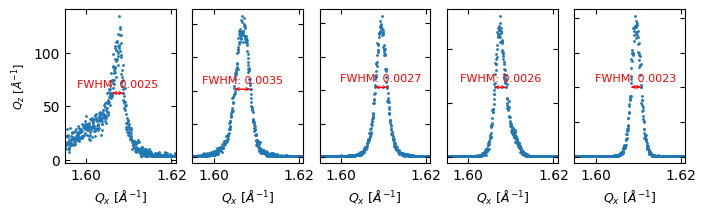

In [282]:
FWHM_list = []

fig, axes = layout_fig(graph=len(files), mod=5, figsize=(8, 2), subplot_style='gridspec', spacing=(0.15, 0.15), layout='tight')
for Qx_line, intensity_line, ax in zip(Qx_lines, intensity_lines, axes):
    ax.scatter(Qx_line, intensity_line, s=1)

    # Calculate FWHM for the STO peak (peak_x[0]) and SRO peak (peak_x[1])
    peak_x, peak_y = detect_peaks(Qx_line, intensity_line, num_peaks=1, prominence=0.1, distance=None)
    fwhm, y_fwhm, x_left, x_right = calculate_fwhm(Qx_line, intensity_line, peak_x[0])

    # Draw FWHM arrows for both peaks
    ax.plot([x_left, x_right], [y_fwhm, y_fwhm], 'r-', lw=0.5)  # 'k-' is for black line
    # No shrink at the starting point and ending point and Controls arrowhead size
    ax.annotate('', xy=(x_right, y_fwhm), xytext=(x_left, y_fwhm),
                arrowprops=dict(arrowstyle='<->', lw=0.8, color='r', shrinkA=0,  shrinkB=0, mutation_scale=5))
    ax.text((x_left + x_right) / 2, y_fwhm*1.05, f'FWHM: {fwhm:.4f}', ha='center', va='bottom', color='r', fontsize=8)
    
    ax.set_xlim(1.595, 1.621)
    ax.tick_params(axis="x", direction="in", top=True)
    ax.tick_params(axis="y", direction="in", right=True)       
    ax.set_xlabel(r'$Q_x$ [$\AA^{-1}$]', fontsize=9)
    FWHM_list.append(fwhm)
    
for ax in axes[1:]:
    ax.set_yticklabels([])
axes[0].set_ylabel(r'$Q_z$ [$\AA^{-1}$]', fontsize=8)
plt.savefig('../figures/2_RSMs_SRO_FWHM.png', dpi=300, bbox_inches='tight')
plt.show()

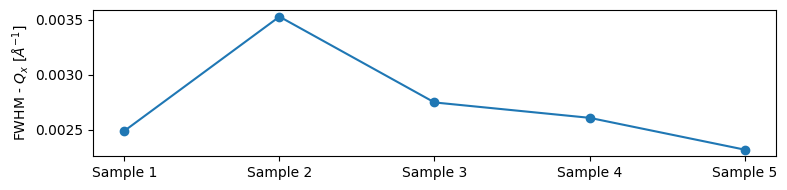

In [293]:
plt.figure(figsize=(8, 2))
plt.plot(sample_names, FWHM_list, marker='o')
plt.ylabel('FWHM - $Q_x$ [$\AA^{-1}$]')
plt.tight_layout()
plt.savefig('../figures/2_RSMs_SRO_FWHM_trend.png', dpi=300, bbox_inches='tight')
plt.show()

### Four angles RSM scans

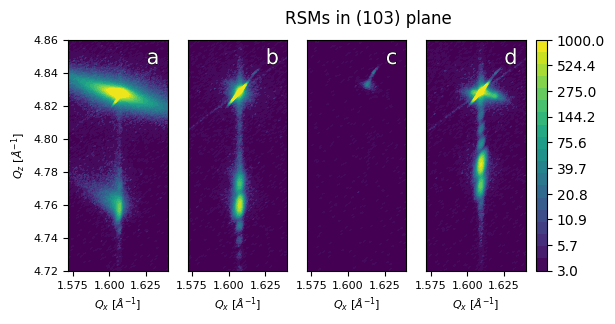

In [204]:
files = glob.glob('../data/XRD_RSM/YG069/YG069*RSM*.xrdml')
files = [files[i] for i in [2,1,0,3]]

fig, axes = layout_fig(graph=len(files), mod=5, figsize=(8, 3), subplot_style='gridspec', spacing=(0.2, 0.2), layout='tight')
for i, (ax, file) in enumerate(zip(axes, files)):
    pattern = r"phi(?:[_ ]| at )(-?\d+\.?\d*)"
    label = 'phi='+re.search(pattern, file).group(1)
    Qx, Qz, intensity = plotter.plot(file, fig, ax, figsize=None)
    labelfigs(ax, i, size=15, inset_fraction=(0.08, 0.15), loc='tr')
plt.suptitle('RSMs in (103) plane')
# plt.tight_layout()
plt.show()

Fig. s1.1 RSMs in different phi angles. a, b, c, d is 0, 90, 180, 270 degrees, respectively.